In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Kiểm tra xem CUDA có khả dụng không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Cấu hình các thông số huấn luyện
num_classes = 36  # Số lượng lớp đầu ra
num_sensors =5
sequence_length=10

In [4]:
# # Khởi tạo dữ liệu giả định và di chuyển nó lên GPU (nếu có sẵn)
# num_samples = 1000
# sequence_length = 100
# X_train = torch.randn(num_samples, num_sensors, sequence_length).to(device)
# y_train = torch.randint(0, num_classes, (num_samples,)).to(device)
# print("Kích thước của x_train:", X_train.shape)
# print("Kích thước của y_train:", y_train.shape)

# #luu du lieu tao duoi dang csv
# import pandas as pd

# # Chuyển đổi tensors PyTorch thành mảng NumPy
# X_train_numpy = X_train.cpu().numpy()
# y_train_numpy = y_train.cpu().numpy()

# # Tạo DataFrame từ dữ liệu
# data = {'x' + str(i+1): X_train_numpy[:, i, :].tolist() for i in range(num_sensors)}
# data['y'] = y_train_numpy.tolist()
# df = pd.DataFrame(data)

# # Lưu DataFrame vào file CSV
# df.to_csv('data.csv', index=False)

# print("File CSV đã được lưu.")
# X_train[0]


In [5]:
#Load du lieu x y tu file csv
import pandas as pd
import ast
import torch

# Đọc dữ liệu từ file CSV vào DataFrame
df = pd.read_csv('data.csv')

# Tách cột 'x' và 'y'
x_data = df[['x1', 'x2', 'x3', 'x4', 'x5']]  # Chọn các cột 'x1', 'x2', 'x3', 'x4', 'x5' làm đặc trưng
y_data = df['y']  # Chọn cột 'y' làm nhãn

# Chuyển đổi dữ liệu 'x' thành tensors PyTorch
x_train = []
for _, row in x_data.iterrows():
    x_values = [ast.literal_eval(val) for val in row.values]  # Phân tích các giá trị từ chuỗi thành danh sách
    x_train.append(torch.tensor(x_values, dtype=torch.float32))
X_train = torch.stack(x_train).to(device)
# Chuyển đổi dữ liệu 'y' thành tensors PyTorch
y_train = torch.tensor(y_data.values, dtype=torch.long).to(device)

# Kiểm tra kích thước của tensors
print("Kích thước của x_train:", X_train.shape)
print("Kích thước của y_train:", y_train.shape)

num_samples = y_train.shape[0]

# X_train[0]

Kích thước của x_train: torch.Size([26846, 5, 10])
Kích thước của y_train: torch.Size([26846])


In [6]:
# Định nghĩa mô hình CNN 1D
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.batch_norm5 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.3)
        self.padding = nn.ConstantPad1d((0, 1), value=0)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1 )
        self.fc = nn.Linear(1024*sequence_length, num_classes)  # Chỉnh kích thước đầu vào của fully connected

    # def forward(self, x):
    #     x = torch.relu(self.batch_norm1(self.conv1(x)))
    #     print(f'Kich thuoc x sau conv1 {x.shape}')
    #     x = torch.relu(self.batch_norm2(self.conv2(x)))
    #     print(f'Kich thuoc x sau conv2 {x.shape}')
    #     x = torch.relu(self.batch_norm3(self.conv3(x)))
    #     print(f'Kich thuoc x sau conv3 {x.shape}')
    #     x = torch.relu(self.batch_norm4(self.conv4(x)))
    #     print(f'Kich thuoc x sau conv4 {x.shape}')
    #     x = torch.relu(self.batch_norm5(self.conv5(x)))
    #     print(f'Kich thuoc x sau conv5 {x.shape}')
    #     # x = torch.max_pool1d(x, kernel_size=2,)
    #     x = self.padding(x)
    #     print(f'Kich thuoc x sau padding {x.shape}')
    #     x = self.maxpool(x)
    #     print(f'Kich thuoc x sau maxpol {x.shape}')
    #     x = self.dropout(x)
    #     print(f'Kich thuoc x sau dropout {x.shape}')
    #     x = x.view(x.size(0), -1)  # Kích thước phẳng (flattening)
    #     print(f'Kich thuoc x sau x.view {x.shape}')
    #     x = self.fc(x)
    #     return x
# # Khởi tạo mô hình
# input_size = num_sensors  # Số lượng cảm biến
# model = CNN1D(input_size=input_size, num_classes=num_classes).to(device)

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    # def forward(self, x):
    #     # Khởi tạo hidden state và cell state ban đầu
    #     h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    #     c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    #     # Đi qua LSTM
    #     out, _ = self.lstm(x, (h0, c0))

    #     # Chỉ lấy thông tin từ timestep cuối cùng
    #     out = out[:, -1, :]

    #     # Đi qua tầng fully connected
    #     out = self.fc(out)

    #     # Áp dụng hàm kích hoạt ReLU
    #     out = self.relu(out)
    #     return out

# # Khởi tạo mô hình
# input_size = 100  # Mỗi chuỗi kênh đầu vào có kích thước 1x100
# hidden_size = 1024  # Số hidden unit
# num_layers = 2  # Số lớp LSTM
# num_classes = 36  # Số lớp đầu ra
# dropout_rate = 0.3  # Tỉ lệ dropout

# model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout_rate)

# # Kiểm tra mô hình với batch size là 32, 1024 chuỗi, mỗi chuỗi 100 timesteps
# test_input = torch.randn(32, 1024, 100)  # Batch size là 32
# output = model(test_input)
# print(output.shape)  # Kết quả đầu ra sẽ có kích thước [32, 36]

In [8]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNLSTM, self).__init__()
        # Khai báo phần CNN
        self.cnn = CNN1D(input_size=input_size, num_classes=num_classes)
        # Khai báo phần LSTM
        self.lstm = LSTMModel(input_size=1024, hidden_size=1024, num_layers=2, num_classes=num_classes, dropout_rate=0.3)

    def forward(self, x):
        batch_size, _, _ = x.shape
        # Qua CNN
        x = self.cnn.conv1(x)
        x = torch.relu(self.cnn.batch_norm1(x))
        x = self.cnn.conv2(x)
        x = torch.relu(self.cnn.batch_norm2(x))
        x = self.cnn.conv3(x)
        x = torch.relu(self.cnn.batch_norm3(x))
        x = self.cnn.conv5(x)
        x = torch.relu(self.cnn.batch_norm5(x))
        x = self.cnn.padding(x)
        x = self.cnn.maxpool(x)
        x = self.cnn.dropout(x)
        # print(f"kich thuoc x sau dropout: {x.shape}")
        # print(x)
        # Thay đổi hình dạng để phù hợp với đầu vào của LSTM
        x = x.transpose(1, 2)  # Transpose để phù hợp chiều với LSTM
        x = x.contiguous().view(batch_size, -1, 1024)  # Sắp xếp lại để có kích thước phù hợp cho LSTM
        # print(f"kich thuoc x sau contiguous: {x.shape}")
        # print(x)

        # Qua LSTM
        # x = self.lstm(x)

        # Khởi tạo hidden state và cell state ban đầu
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        # Đi qua LSTM
        x, _ = self.lstm.lstm(x, (h0, c0))
        # print(f"kich thuoc x sau lstm: {x.shape}")
        # print(x)
        # Chỉ lấy thông tin từ timestep cuối cùng
        x = x[:, -1, :]

        # print(f"kich thuoc x sau timestep cuoi: {x.shape}")
        # print(x)

        # Đi qua tầng fully connected
        x = self.lstm.fc(x)
        # Áp dụng hàm kích hoạt ReLU
        x = self.lstm.relu(x)
        # print(f"kich thuoc x sau fc: {x.shape}")
        # print(x)

        return x
# Khởi tạo mô hình
input_size = num_sensors  # Số lượng cảm biến
model = CNNLSTM(input_size=input_size, num_classes=num_classes).to(device)

In [9]:
# # Chọn một mẫu ngẫu nhiên từ tập dữ liệu đào tạo
# sample_index = np.random.randint(0,num_samples)

# # Lấy dữ liệu và nhãn của mẫu đã chọn
# sample_data = X_train[sample_index].cpu().numpy()  # Chuyển dữ liệu về CPU và numpy array
# sample_label = y_train[sample_index].item()

# # Vẽ dữ liệu từng cảm biến
# plt.figure(figsize=(10, 6))
# # Plot data for each sensor
# for i in range(num_sensors):
#         plt.plot(sample_data[i], label=f"Sensor {i+1}")

# # # Check if the first dimension has more than one element
# # if sample_data.shape[0] > 1:
# #     # Plot data for each sensor
# #     for i in range(num_sensors):
# #         plt.plot(sample_data[i], label=f"Sensor {i+1}")
# # else:
# #     # If only one element, plot directly
# #     plt.plot(sample_data[0], label="Sensor 1")

# plt.title('Sensor Data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

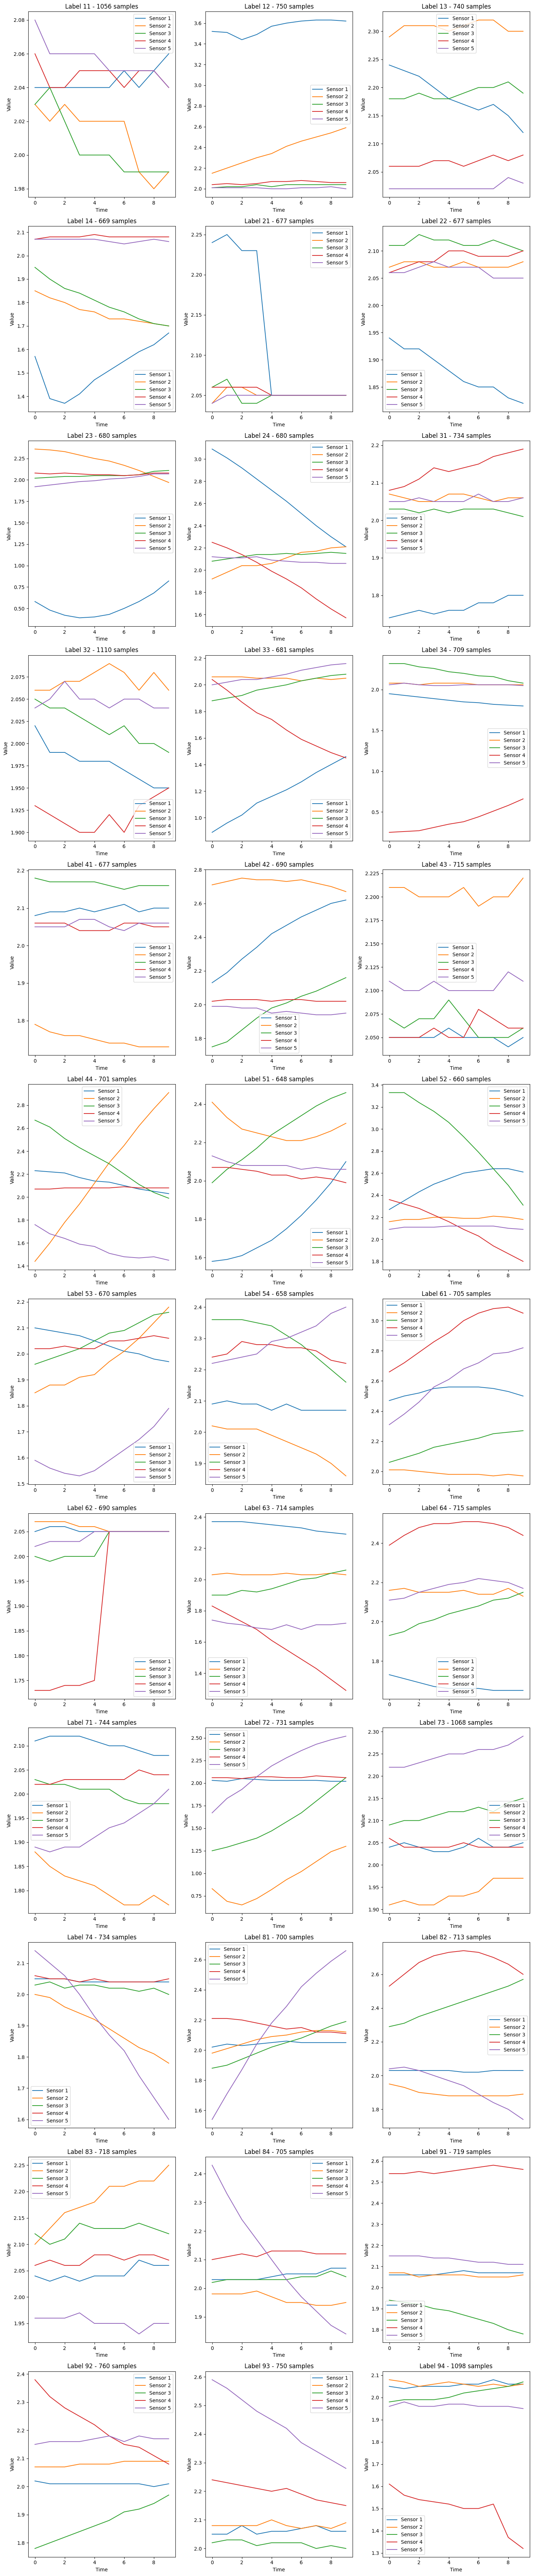

In [10]:
# Chọn một mẫu ngẫu nhiên mỗi nhãn từ tập dữ liệu đào tạo để vẽ và note lại số lượng sample mỗi nhãn

# Giả sử X_train và y_train là các tensor PyTorch chứa dữ liệu và nhãn tương ứng
# num_samples là tổng số mẫu trong tập dữ liệu
# num_sensors là số lượng cảm biến

# Số lượng nhãn
unique_labels = torch.unique(y_train)
num_labels = len(unique_labels)

# Tạo một dictionary để lưu trữ mẫu ngẫu nhiên cho mỗi nhãn
samples_per_label = {}

# Chọn ngẫu nhiên một mẫu cho mỗi nhãn
for label in unique_labels:
    # Lấy các chỉ số của các mẫu có nhãn hiện tại
    indices = (y_train == label).nonzero(as_tuple=True)[0]
    # Chọn ngẫu nhiên một chỉ số từ các chỉ số này
    sample_index = np.random.choice(indices.cpu().numpy())
    # Lưu trữ dữ liệu và nhãn của mẫu đã chọn
    sample_data = X_train[sample_index].cpu().numpy()
    sample_label = y_train[sample_index].item()
    samples_per_label[sample_label] = (sample_data, len(indices))

# Xác định số hàng cần thiết dựa trên số nhãn và số cột (3)
num_cols = 3
num_rows = int(np.ceil(num_labels / num_cols))

# Vẽ dữ liệu của từng mẫu đã chọn
plt.figure(figsize=(15, num_rows * 6))

for idx, (label, (data, count)) in enumerate(samples_per_label.items()):
    plt.subplot(num_rows, num_cols, idx + 1)
    for i in range(num_sensors):
        plt.plot(data[i], label=f"Sensor {i+1}")
    plt.title(f'Label {label} - {count} samples')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# Huấn luyện mô hình
num_epochs = 100
batch_size = 32
learning_rate = 0.0001
weight_decay = 0.0001  # L2 regularization

# Khởi tạo optimizer và loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [12]:
import torch.utils.data as data

# Tổng số mẫu
total_samples = len(X_train)

# Tính số lượng mẫu cho tập huấn luyện và tập kiểm tra
train_size = int(0.8 * total_samples)  # 80% cho tập huấn luyện
test_size = total_samples - train_size  # 20% cho tập kiểm tra

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, y_train), [train_size, test_size])

# Khởi tạo DataLoader cho cả tập huấn luyện và tập kiểm tra
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Đường dẫn đến tệp tin chứa trạng thái của mô hình
model_file_path = 'my_model.pth'

# Kiểm tra xem tệp tin tồn tại hay không
if os.path.isfile(model_file_path):
    # Nếu tệp tin tồn tại, tải trạng thái của mô hình từ tệp tin đã lưu
    model.load_state_dict(torch.load(model_file_path))
    print("Đã tải mô hình từ tệp tin đã lưu.")
else:
    print("Không tìm thấy tệp tin của mô hình.")

Đã tải mô hình từ tệp tin đã lưu.


In [ ]:
# Tạo label map từ chuỗi nhãn sang chỉ mục nguyên
label_map = {}
index = 0
for i in range(1, 10):
    for j in range(1, 5):
        # Biểu diễn vị trí của mỗi ô trong lưới 9x4 dưới dạng chuỗi
        label = f"{i}{j}"
        # Ánh xạ chuỗi nhãn sang chỉ mục nguyên
        label_map[label] = index
        index += 1

# In label map để kiểm tra
print(label_map)


# Hàm chuyển đổi chuỗi nhãn thành chỉ mục nguyên
def label_to_index(labels):
    # Chuyển đổi tensor labels về list giá trị của nó
    labels_list = [str(label.item()) for label in labels]
    # Sử dụng list giá trị để truy cập từ điển ánh xạ
    return torch.tensor([label_map[label] for label in labels_list])

# Tạo từ điển ánh xạ từ chỉ mục lớp sang nhãn
index_to_label = {index: label for label, index in label_map.items()}

# Hàm chuyển đổi chỉ mục thành nhãn
def index_to_label_func(index):
    return index_to_label[index]


{'11': 0, '12': 1, '13': 2, '14': 3, '21': 4, '22': 5, '23': 6, '24': 7, '31': 8, '32': 9, '33': 10, '34': 11, '41': 12, '42': 13, '43': 14, '44': 15, '51': 16, '52': 17, '53': 18, '54': 19, '61': 20, '62': 21, '63': 22, '64': 23, '71': 24, '72': 25, '73': 26, '74': 27, '81': 28, '82': 29, '83': 30, '84': 31, '91': 32, '92': 33, '93': 34, '94': 35}


In [ ]:
train_losses=[]
# Huấn luyện mô hình
for epoch in range(num_epochs):
    model.train()  # Chuyển sang chế độ huấn luyện
    running_loss = 0.0
    for inputs, labels_str in train_loader:
        inputs, labels_str = inputs.to(device), labels_str

        # Chuyển đổi nhãn thành chỉ mục nguyên
        labels = label_to_index(labels_str).to(device)

        # Feedforward
        outputs = model(inputs)

        # Tính loss và backward
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Lưu trữ loss cho epoch hiện tại
    train_losses.append(running_loss / (num_samples / batch_size))

    if (epoch+1)%10==0:
      # Lưu trạng thái của mô hình vào một tệp tin
      torch.save(model.state_dict(), model_file_path)
      print(f'Da luu model: {model_file_path}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished!')


Epoch [1/100], Loss: 3.4258
Epoch [2/100], Loss: 4.4469
Epoch [3/100], Loss: 2.0959
Epoch [4/100], Loss: 2.3970
Epoch [5/100], Loss: 2.2752
Epoch [6/100], Loss: 1.9372
Epoch [7/100], Loss: 2.0759
Epoch [8/100], Loss: 3.1231
Epoch [9/100], Loss: 1.9837
Da luu model: my_model.pth
Epoch [10/100], Loss: 1.4412
Epoch [11/100], Loss: 1.1319
Epoch [12/100], Loss: 3.8404
Epoch [13/100], Loss: 3.3540
Epoch [14/100], Loss: 3.4177
Epoch [15/100], Loss: 0.7800
Epoch [16/100], Loss: 0.6045
Epoch [17/100], Loss: 1.3630
Epoch [18/100], Loss: 1.1849
Epoch [19/100], Loss: 0.5091
Da luu model: my_model.pth
Epoch [20/100], Loss: 2.5842
Epoch [21/100], Loss: 0.1249
Epoch [22/100], Loss: 1.1833
Epoch [23/100], Loss: 0.2102
Epoch [24/100], Loss: 0.7059
Epoch [25/100], Loss: 0.2142
Epoch [26/100], Loss: 1.3485
Epoch [27/100], Loss: 2.9926
Epoch [28/100], Loss: 1.9214
Epoch [29/100], Loss: 1.0336
Da luu model: my_model.pth
Epoch [30/100], Loss: 0.7097
Epoch [31/100], Loss: 1.0688
Epoch [32/100], Loss: 0.2798


In [ ]:
print(outputs.shape)

torch.Size([4, 36])


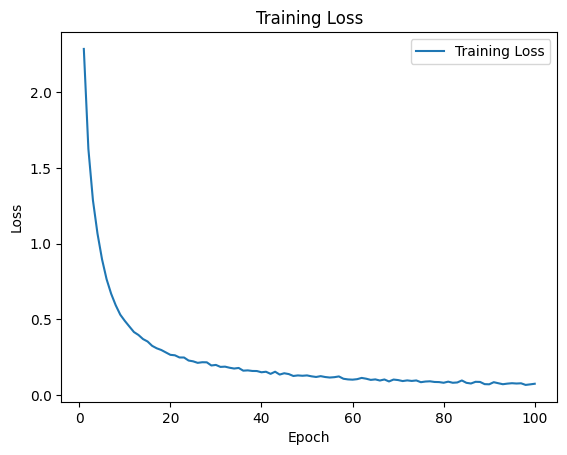

In [ ]:
# Vẽ đồ thị loss qua các epoch
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# # Giả sử model đã được huấn luyện và có tên là model

# # Chuỗi đầu vào
# input_sequence = torch.randn(1, 5, 10)  # Giả sử kích thước của chuỗi là (1, 5, 100)

# # Vẽ dữ liệu từng cảm biến
# plt.figure(figsize=(10, 6))
# for i in range(num_sensors):
#     plt.plot(input_sequence[0][i], label=f"Sensor {i+1}")
# plt.title('Sensor Data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Dự đoán đầu ra
# with torch.no_grad():
#     output = model(input_sequence.to(device))

# # Xử lý đầu ra để có được dự đoán cuối cùng
# predicted_class = torch.argmax(output, dim=1)
# predicted_label = index_to_label_func(predicted_class.item())

# print("Dự đoán cuối cùng:", predicted_label)

In [ ]:
TP=0
number_sample=0
# Tạo DataLoader từ test_dataset với batch_size=1 và shuffle=True
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
model.eval()
# Lấy một mẫu ngẫu nhiên từ DataLoader
for input_sequence, label in data_loader:
    # Dự đoán đầu ra cho mẫu đã lấy ngẫu nhiên
    with torch.no_grad():
        output = model(input_sequence.to(device))

    # Xử lý đầu ra để có được dự đoán cuối cùng
    predicted_class = torch.argmax(output, dim=1)
    predicted_label = index_to_label_func(predicted_class.item())


    number_sample+=1

    if str(label.item()) == predicted_label:
        TP += 1
    else:
        print("Nhãn của mẫu-Dự đoán:", label.item(),"-", predicted_label)

Acc=TP/number_sample
print("Độ chính xác",Acc)

Nhãn của mẫu-Dự đoán: 42 - 41
Nhãn của mẫu-Dự đoán: 33 - 34
Nhãn của mẫu-Dự đoán: 0 - 32
Nhãn của mẫu-Dự đoán: 12 - 22
Nhãn của mẫu-Dự đoán: 11 - 32
Nhãn của mẫu-Dự đoán: 12 - 21
Nhãn của mẫu-Dự đoán: 73 - 83
Nhãn của mẫu-Dự đoán: 54 - 63
Nhãn của mẫu-Dự đoán: 0 - 32
Nhãn của mẫu-Dự đoán: 74 - 73
Nhãn của mẫu-Dự đoán: 73 - 74
Nhãn của mẫu-Dự đoán: 91 - 92
Nhãn của mẫu-Dự đoán: 32 - 0
Nhãn của mẫu-Dự đoán: 93 - 11
Nhãn của mẫu-Dự đoán: 93 - 84
Nhãn của mẫu-Dự đoán: 0 - 11
Nhãn của mẫu-Dự đoán: 61 - 52
Nhãn của mẫu-Dự đoán: 91 - 92
Nhãn của mẫu-Dự đoán: 32 - 0
Nhãn của mẫu-Dự đoán: 41 - 11
Nhãn của mẫu-Dự đoán: 23 - 12
Nhãn của mẫu-Dự đoán: 61 - 32
Nhãn của mẫu-Dự đoán: 73 - 74
Nhãn của mẫu-Dự đoán: 21 - 11
Nhãn của mẫu-Dự đoán: 13 - 11
Nhãn của mẫu-Dự đoán: 32 - 22
Nhãn của mẫu-Dự đoán: 13 - 12
Nhãn của mẫu-Dự đoán: 53 - 81
Nhãn của mẫu-Dự đoán: 94 - 93
Nhãn của mẫu-Dự đoán: 0 - 22
Nhãn của mẫu-Dự đoán: 94 - 0
Nhãn của mẫu-Dự đoán: 33 - 21
Nhãn của mẫu-Dự đoán: 42 - 14
Nhãn của mẫu-Dự đ

In [ ]:
import numpy as np

# Khởi tạo ma trận confusion
confusion_matrix = np.zeros((num_classes, num_classes))

# Tạo DataLoader từ test_dataset với batch_size=1 và shuffle=True
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
model.eval()

# Lấy một mẫu ngẫu nhiên từ DataLoader và cập nhật ma trận confusion
for input_sequence, label in data_loader:
    # Dự đoán đầu ra cho mẫu đã lấy ngẫu nhiên
    with torch.no_grad():
        output = model(input_sequence.to(device))

    # Xử lý đầu ra để có được dự đoán cuối cùng
    predicted_class = torch.argmax(output, dim=1).item()
    true_label = label_to_index(label).item()  # Ánh xạ nhãn thực tế sang chỉ số số nguyên

    # Đảm bảo nhãn trong phạm vi [0, num_classes-1]
    if 0 <= predicted_class < num_classes and 0 <= true_label < num_classes:
        # Cập nhật ma trận confusion
        confusion_matrix[true_label, predicted_class] += 1

# Tính Precision, Recall và F1 score cho mỗi nhãn
precisions = []
recalls = []
f1_scores = []
for i in range(num_classes):
    # Tính TP, FP, FN cho nhãn i
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP

    # Tính Precision, Recall và F1 score cho nhãn i
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Tính trung bình Precision, Recall và F1 score trên tất cả các nhãn
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 score:", average_f1_score)


Average Precision: 0.9041207462851897
Average Recall: 0.9019583496215862
Average F1 score: 0.9018940055874826


Nhãn của mẫu: 52


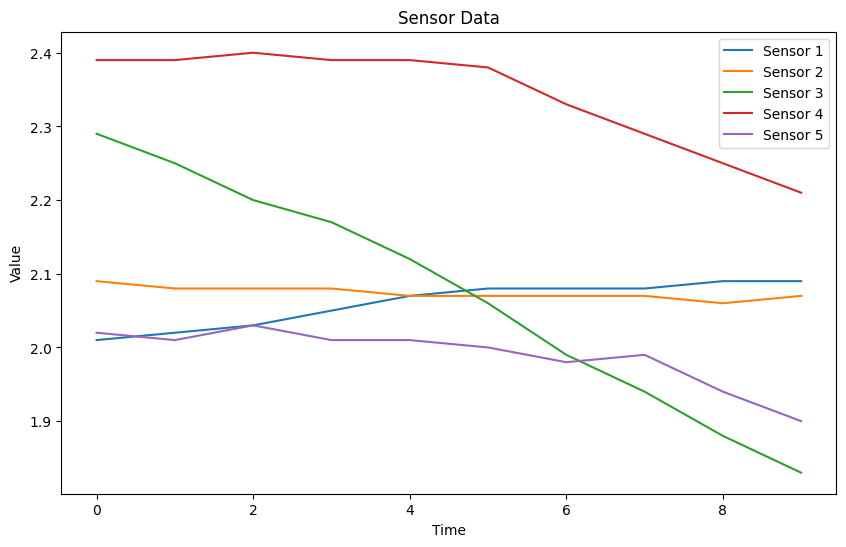

Dự đoán cuối cùng: 52


In [ ]:
# Tạo DataLoader từ test_dataset với batch_size=1 và shuffle=True
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Lấy một mẫu ngẫu nhiên từ DataLoader
for input_sequence, label in data_loader:
    # In nhãn của mẫu
    print("Nhãn của mẫu:", label.item())

    # Vẽ dữ liệu từng cảm biến
    plt.figure(figsize=(10, 6))
    for i in range(num_sensors):
        plt.plot(input_sequence[0][i].cpu(), label=f"Sensor {i+1}")
    plt.title('Sensor Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Dự đoán đầu ra cho mẫu đã lấy ngẫu nhiên
    with torch.no_grad():
        output = model(input_sequence.to(device))

    # Xử lý đầu ra để có được dự đoán cuối cùng
    predicted_class = torch.argmax(output, dim=1)
    predicted_label = index_to_label_func(predicted_class.item())

    print("Dự đoán cuối cùng:", predicted_label)

    # Dừng sau khi lấy một mẫu
    break
